## Imports

In [44]:
import pandas as pd
import glob
import os


# Import data
filename = 'outputs/results/combined_enterprise_output.csv'

df = pd.read_csv(filename)

# Filter vendors in case we need more filtering 
excluded_vendors_file = "config/excluded_vendors.txt"
with open(excluded_vendors_file, 'r', encoding='utf-8') as file:
    excluded_vendors = {line.strip() for line in file if line.strip()}

# Convert engine time (seconds) to datetime relative to current time
df['Engine_Age'] = pd.Timestamp.now() - pd.to_timedelta(df['Engine Time'], unit='s')
# Filter out rows with engine time before 1998
df = df[df['Engine_Age'].dt.year >= 1998]
print(df['Engine_Age'])

size_before = df.shape[0]
print(excluded_vendors)
df = df[~df["Vendor"].isin(excluded_vendors)]
df = df[df["Vendor"] != 'unknown']
print("Dropped " + str(size_before - df.shape[0]) + " by vendor exclusion.\n" + str(df.shape[0]) + " entries left.")
print(df.columns)

0      2025-05-14 18:50:27.370178
1      2025-06-01 18:54:13.370178
2      2025-05-04 13:24:45.370178
3      2021-05-04 10:57:29.370178
4      2025-05-09 20:35:23.370178
                  ...            
7594   2025-06-10 05:56:34.370178
7595   2024-07-16 15:48:56.370178
7596   2023-03-17 21:49:03.370178
7597   2023-03-17 21:23:24.370178
7598   2022-04-24 02:43:13.370178
Name: Engine_Age, Length: 7377, dtype: datetime64[ns]
{'ciscoSystems', 'Juniper Networks, Inc.', 'HUAWEI Technology Co.,Ltd', 'net-snmp'}
Dropped 2233 by vendor exclusion.
5144 entries left.
Index(['IP', 'Enterprise Code', 'MAC', 'Engine Time', 'Engine Boots', 'Vendor',
       'Scan Date', 'Reboot Date', 'Engine_Age'],
      dtype='object')


### Popular Vendors:


Vendor Counts:
Vendor
Ambit Microsystems Corporation                                             1407
Thomson Inc.                                                               1008
Brocade Communications Systems, Inc.                                        639
H3C                                                                         436
Brocade Communication Systems, Inc. (formerly 'Foundry Networks, Inc.')     366
Fortinet, Inc.                                                              262
Nokia (formerly 'Alcatel-Lucent')                                           251
Compaq                                                                      219
SonicWALL, Inc.                                                             154
Broadcom Limited                                                             90
Name: count, dtype: int64


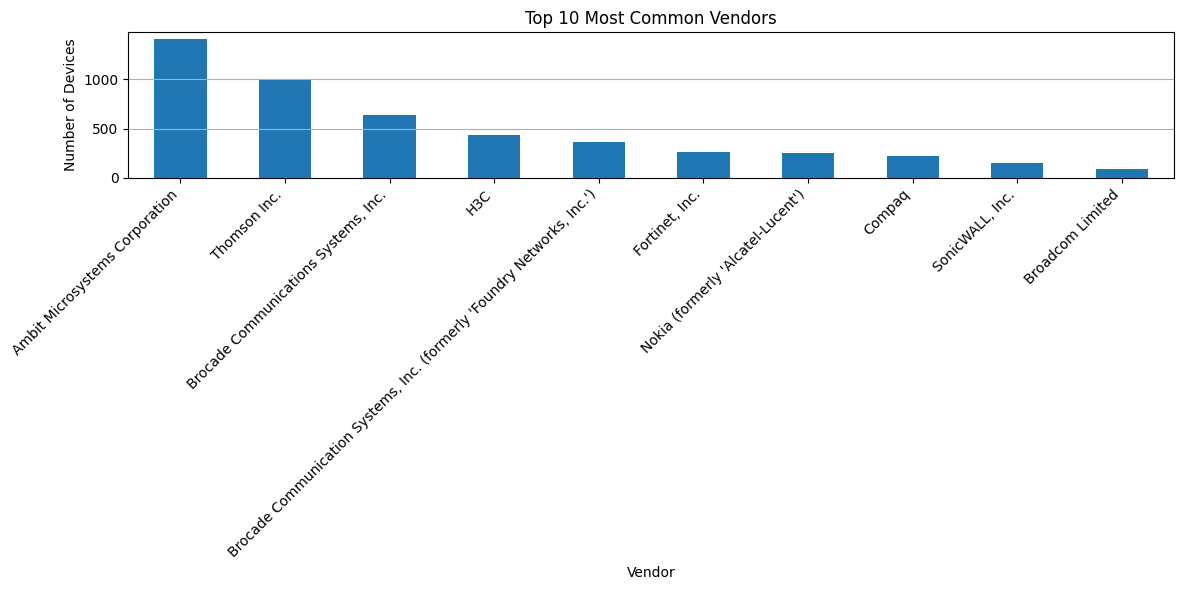

In [33]:
import matplotlib.pyplot as plt

# Get top 10 vendors by count
vendor_counts = df['Vendor'].value_counts().head(10)

# Create bar plot
plt.figure(figsize=(12, 6))
vendor_counts.plot(kind='bar')
plt.title('Top 10 Most Common Vendors')
plt.xlabel('Vendor')
plt.ylabel('Number of Devices')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()

# Print exact counts
print("\nVendor Counts:")
print(vendor_counts)

### Fetch CVEs for vendor:

In [ ]:
import datetime
from cve_matching import translate_vendor, fetch_CVEs_with_split

# Fetch CVEs for vendor
vendor = 'SonicWALL, Inc.'#NetScreen Technologies, Inc.'#SonicWALL, Inc.'Fortinet, Inc.'
max_engine_time = df[df["Vendor"] == vendor]["Engine Time"].max()
latest_reboot_date = max(df["Reboot Date"], key=lambda x: datetime.datetime.strptime(x, "%m_%d_%Y_%H_%M_%S"))
latest_reboot_datetime = datetime.datetime.strptime(latest_reboot_date, "%m_%d_%Y_%H_%M_%S")
translated_vendor = translate_vendor(vendor)
cves = fetch_CVEs_with_split(translated_vendor, max_engine_time, end_date=latest_reboot_datetime)

print("Largest Engine Time for", vendor, ":", max_engine_time)
print("Number of CVEs found:", len(cves))

{'ciscoSystems', 'Juniper Networks, Inc.', 'HUAWEI Technology Co.,Ltd', 'net-snmp'}
Dropped 0 by vendor exclusion.
5366 entries left.
Index(['IP', 'Enterprise Code', 'MAC', 'Engine Time', 'Engine Boots', 'Vendor',
       'Scan Date', 'Reboot Date'],
      dtype='object')
Largest Engine Time for SonicWALL, Inc. : 58170272.0
Number of CVEs found: 22

Vendor distribution:
Vendor
Ambit Microsystems Corporation                                             1407
Thomson Inc.                                                               1008
Brocade Communications Systems, Inc.                                        639
H3C                                                                         436
Brocade Communication Systems, Inc. (formerly 'Foundry Networks, Inc.')     366
                                                                           ... 
Opengear Inc.                                                                 1
Acme Packet                                                  

### Vulnerable IPs over time:

2023-07-31 11:16:51


/tmp/ipykernel_130131/4266881502.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Reboot_Datetime'] = pd.to_datetime(df_filtered['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')


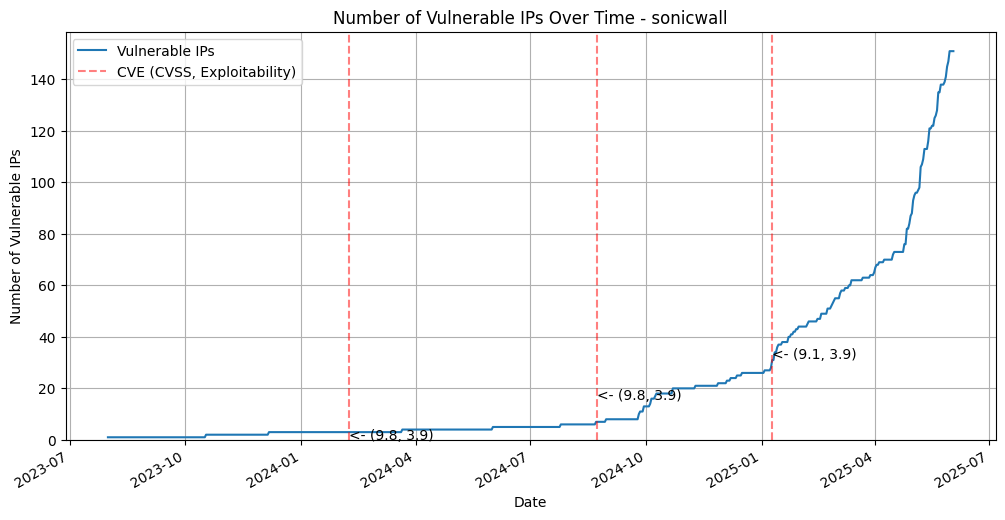

In [28]:
import matplotlib.pyplot as plt

# Convert reboot dates to datetime
# Filter dataframe for specified vendor
df_filtered = df[df['Vendor'] == vendor]
df_filtered['Reboot_Datetime'] = pd.to_datetime(df_filtered['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')
df_filtered = df_filtered[df_filtered['Reboot_Datetime'].dt.year >= 1998]

# Create time series of vulnerability counts
print(df_filtered['Reboot_Datetime'].min())
time_range = pd.date_range(start=df_filtered['Reboot_Datetime'].min(), end=df_filtered['Reboot_Datetime'].max(), freq='D')
vulnerable_counts = []

for time_point in time_range:
    # Count IPs with reboot time older than this date (vulnerable)
    vulnerable_ips = df_filtered[df_filtered['Reboot_Datetime'] <= time_point]['IP'].nunique()
    vulnerable_counts.append(vulnerable_ips)

# Create and plot the time series
vulnerability_ts = pd.Series(vulnerable_counts, index=time_range)
vulnerability_ts.plot(figsize=(12, 6))
plt.title(f'Number of Vulnerable IPs Over Time - {translated_vendor}')
plt.xlabel('Date')
plt.ylabel('Number of Vulnerable IPs')
plt.grid(True)
plt.ylim(bottom=0)  # Force y-axis to start at 0

start_date = df_filtered['Reboot_Datetime'].min()
end_date = df_filtered['Reboot_Datetime'].max()

for _, cve in cves.iterrows():
    cve_id = cve['CVE_ID']
    published_str = cve['Published']
    cve_date = pd.to_datetime(published_str).normalize()

# Create a dictionary to store highest scoring CVE per date
cve_highest_scores = {}
for _, cve in cves.iterrows():
    cve_date = pd.to_datetime(cve['Published']).normalize()
    if cve['CVSS_Score'] > 7 and cve['Exploitablity_Score'] > 3:
        if cve_date >= start_date and cve_date <= end_date:
            current_score = cve['CVSS_Score'] + cve['Exploitablity_Score']
            if cve_date not in cve_highest_scores or current_score > cve_highest_scores[cve_date]['score']:
                cve_highest_scores[cve_date] = {
                    'score': current_score,
                    'cvss': cve['CVSS_Score'],
                    'exploitability': cve['Exploitablity_Score']
                }

# Plot the highest scoring CVE per date
i = 0
for cve_date, scores in cve_highest_scores.items():
    plt.axvline(x=cve_date, color='r', linestyle='--', alpha=0.5)
    text_height = plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * (0.1 * (i % 10))
    plt.text(cve_date, text_height, f'<- ({scores["cvss"]:.1f}, {scores["exploitability"]:.1f})', 
             horizontalalignment='left', alpha=1)
    i += 1
plt.legend(['Vulnerable IPs', 'CVE (CVSS, Exploitability)'])

/tmp/ipykernel_130131/2407310557.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['Scan Date'] = pd.to_datetime(df_top10['Scan Date'], format='%m_%d_%H_%M_%S')
/tmp/ipykernel_130131/2407310557.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['Reboot Date'] = pd.to_datetime(df_top10['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')
/tmp/ipykernel_130131/2407310557.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

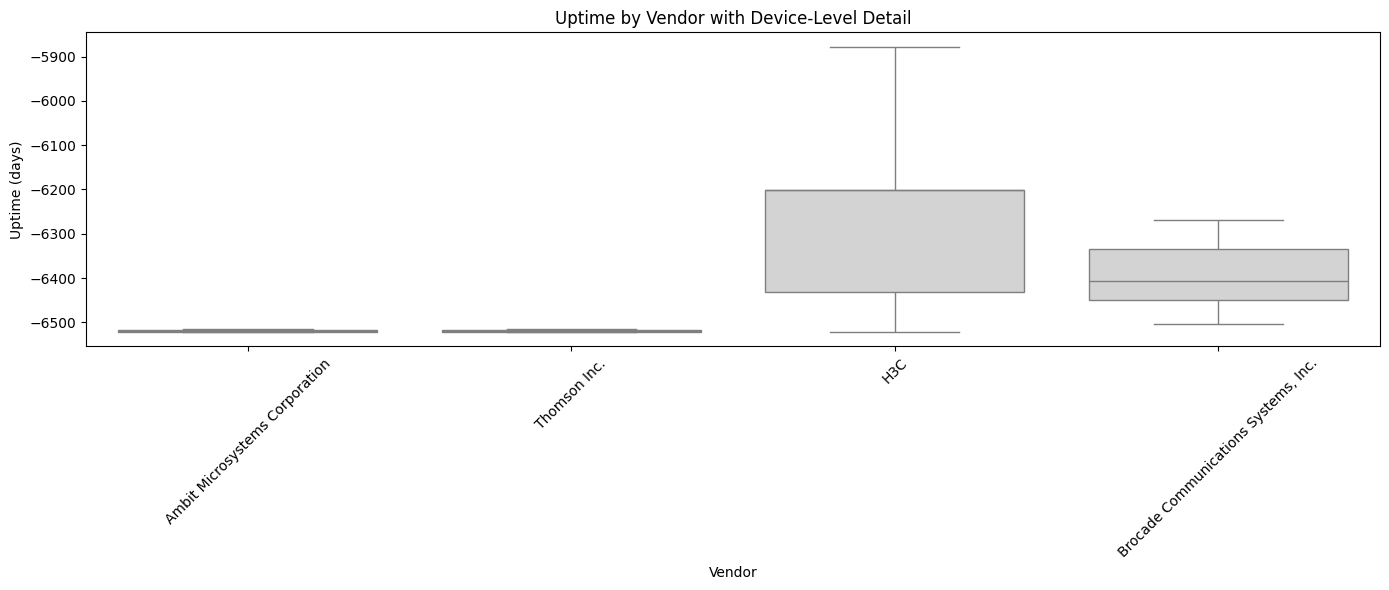

Empty DataFrame
Columns: [CVE_ID, Description, Published, CVSS_Score, Severity, CVSS_Version, EPSS_Score]
Index: []


In [30]:
import seaborn as sns
# Get top 10 vendors by count
top_10_vendors = df['Vendor'].value_counts().head(4).index
df_top10 = df[df['Vendor'].isin(top_10_vendors)]

df_top10['Scan Date'] = pd.to_datetime(df_top10['Scan Date'], format='%m_%d_%H_%M_%S')

df_top10['Reboot Date'] = pd.to_datetime(df_top10['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')
df_top10['Uptime_Days'] = (df_top10['Scan Date'] - df_top10['Reboot Date']).dt.days / 7
# Convert Reboot Date to datetime for better handling
plt.figure(figsize=(14, 6))
sns.boxplot(x='Vendor', y='Uptime_Days', data=df_top10, color='lightgray', showfliers=False)
#sns.swarmplot(x='Vendor', y='Uptime_Days', data=df_top10, size=4, alpha=0.6)
plt.xticks(rotation=45)
plt.title('Uptime by Vendor with Device-Level Detail')
plt.ylabel('Uptime (days)')
plt.xlabel('Vendor')
plt.tight_layout()
plt.show()
# Calculate uptime in weeks

print(cves.head(0))

### Average engine time per vendor:

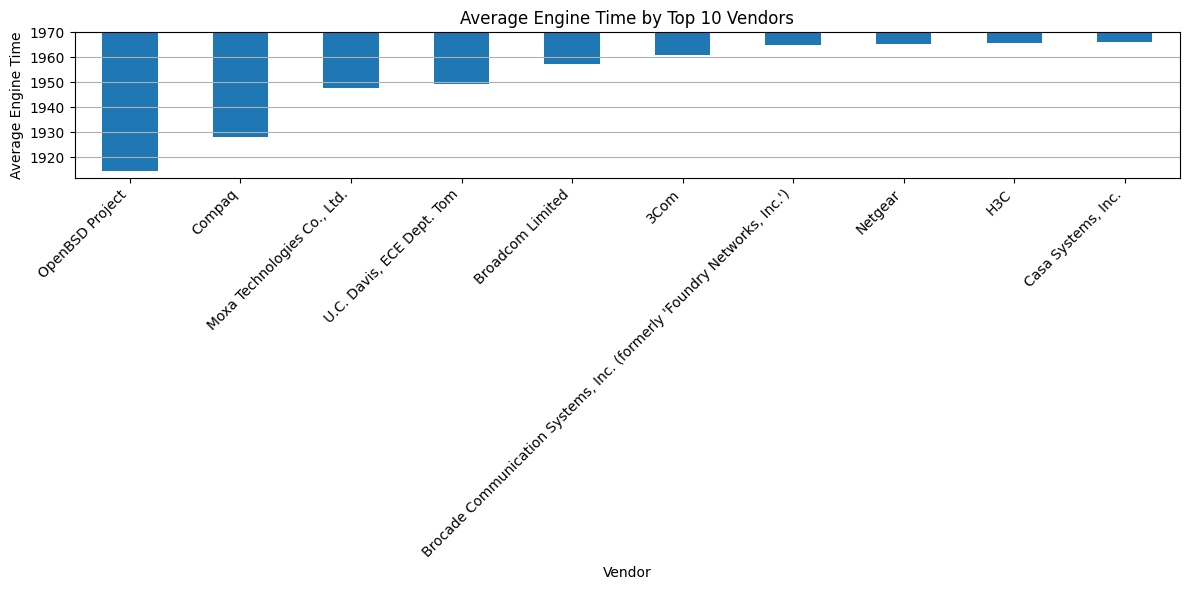

In [38]:
# Calculate average engine time per vendor
avg_engine_time = df.groupby('Vendor')['Engine Time'].mean().sort_values(ascending=False).head(10)
avg_engine_time = avg_engine_time / (7 * 24 * 60 * 60)  # Convert to weeks
# Create bar plot
# Convert seconds to datetime based on latest reboot date
latest_date = pd.to_datetime(df['Reboot Date'].max(), format='%m_%d_%Y_%H_%M_%S')
avg_engine_age = latest_date - pd.to_timedelta(df.groupby('Vendor')['Engine Time'].mean(), unit='s')
avg_engine_age = avg_engine_age.sort_values(ascending=True).head(10)
plt.figure(figsize=(12, 6))
avg_engine_age.plot(kind='bar')
plt.title('Average Engine Time by Top 10 Vendors')
plt.xlabel('Vendor')
plt.ylabel('Average Engine Time')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Convert engine time to weeks for better readability

plt.grid(True, axis='y')